# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2019-09-10 01:36:33,279 INFO    : root         : Using LISA logging configuration:
2019-09-10 01:36:33,281 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2019-09-10 01:36:33,519 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2019-09-10 01:36:33,534 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

## Defines

In [5]:
#file_name = 'G9750/com.eg.android.AlipayGphone_1.html'
file_name = 'com.eg.android.AlipayGphone_3.html'

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnQTIwN0ZTSDkvQTIwN0ZTSDlfUE9TX2ludGVybmV0MicsIGxheW91dD1MYXlvdXQod2lkdGg9dScyMDDigKY=


## Run cells

In [44]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [45]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-1]]
filelist

[[u'/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/Setting/A207FSH9_POS_190822_190822_112631_setting.html',
  u'/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/Setting/A207FSH9_POS_190822_190822_091142_setting.html',
  u'/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/Setting/A207FSH9_POS_190822_190822_102948_setting.html'],
 [u'/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/Setting/A605GSG3_POS_190822_190822_112631_setting.html',
  u'/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/Setting/A605GSG3_POS_190822_190822_091142_setting.html',
  u'/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/Setting/A605GSG3_POS_190822_190822_102948_setting.html']]

## Read Files

In [46]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [47]:
group1.run()
group2.run()

Parsing 91496 lines are Ok
Parsing 89419 lines are Ok
Parsing 85716 lines are Ok
Parsing 83067 lines are Ok
Parsing 81548 lines are Ok
Parsing 89940 lines are Ok


## Analysis

### The timing of marking data

In [48]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

A207FSH9_POS_190822_190822_112631_setting


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1378.0,NaN,NaN,NaN,NaN,NaN,0.106,786.621
3140.0,2.508,1.441,NaN,NaN,NaN,NaN,NaN
7207.0,33.920,44.621,NaN,618.59,NaN,48.100,NaN
1489.0,1.403,0.017,NaN,NaN,NaN,NaN,NaN
1490.0,0.807,0.497,NaN,NaN,NaN,NaN,NaN
7576.0,NaN,NaN,74.219,NaN,15.744,NaN,NaN
1916.0,0.230,0.163,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
7201.0,33.335,47.080,NaN,620.572,NaN,42.998,NaN
1924.0,0.344,0.170,NaN,NaN,NaN,NaN,NaN
1381.0,NaN,NaN,NaN,NaN,NaN,NaN,783.613
1490.0,0.862,0.446,NaN,NaN,NaN,NaN,NaN
3088.0,2.691,3.306,NaN,NaN,NaN,NaN,NaN
1489.0,2.459,1.215,NaN,NaN,NaN,NaN,NaN
7602.0,NaN,NaN,74.276,NaN,9.223,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
7628.0,NaN,NaN,71.934,NaN,13.086,NaN,NaN
3085.0,0.228,1.437,NaN,NaN,NaN,NaN,NaN
1392.0,NaN,NaN,NaN,NaN,NaN,NaN,762.255
1491.0,1.277,1.351,NaN,NaN,NaN,NaN,NaN
1492.0,1.231,0.474,NaN,NaN,NaN,NaN,NaN
7192.0,33.277,45.138,NaN,597.706,NaN,44.172,NaN
1919.0,0.142,0.339,NaN,NaN,NaN,NaN,NaN


In [49]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

A605GSG3_POS_190822_190822_112631_setting


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
3559.0,11.051,NaN,NaN,NaN,NaN,NaN,NaN
1612.0,NaN,NaN,NaN,NaN,NaN,NaN,705.721
1900.0,0.152,0.339,NaN,NaN,NaN,NaN,NaN
8726.0,NaN,NaN,66.132,NaN,10.563,NaN,NaN
8696.0,38.299,59.736,135.353,457.361,11.101,30.246,NaN
3035.0,0.248,1.405,NaN,NaN,NaN,NaN,NaN
1693.0,3.045,1.521,NaN,NaN,NaN,NaN,NaN
1694.0,0.911,0.932,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
8698.0,NaN,NaN,63.434,NaN,10.013,NaN,NaN
2146.0,NaN,NaN,NaN,NaN,NaN,1.990,NaN
1893.0,0.154,0.193,NaN,NaN,NaN,NaN,NaN
1606.0,NaN,NaN,NaN,NaN,NaN,NaN,706.966
3017.0,2.244,3.072,NaN,NaN,NaN,NaN,NaN
1686.0,1.574,1.199,NaN,NaN,NaN,NaN,NaN
1687.0,1.152,0.532,NaN,NaN,NaN,NaN,NaN
3514.0,11.731,NaN,NaN,NaN,NaN,NaN,NaN
8669.0,43.239,57.154,131.625,454.558,11.890,29.856,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
3568.0,13.727,NaN,NaN,NaN,NaN,NaN,NaN
8555.0,NaN,NaN,67.233,NaN,8.819,NaN,NaN
8525.0,40.742,64.606,127.970,467.68,8.901,28.275,NaN
1903.0,0.167,0.199,NaN,NaN,NaN,NaN,NaN
1616.0,NaN,NaN,NaN,NaN,NaN,NaN,719.818
3059.0,0.248,3.519,NaN,NaN,NaN,NaN,NaN
1694.0,3.564,1.464,NaN,NaN,NaN,NaN,NaN
1695.0,0.982,0.855,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

In [50]:
list_of_df = group1.get_marking_time()
count1 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        count1 += 1
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

sum_df1 = DataFrame(sum_df1.sum(axis=0)).swapaxes("index", "columns") 
sum_df1.index = [group1.title]
sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1)


list_of_df = group2.get_marking_time()
count2 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count2 += 1
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching
        
sum_df2 = DataFrame(sum_df2.sum()).swapaxes("index", "columns") 
sum_df2.index = [group2.title]
sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1)

pd.concat([sum_df1 * 1000 / count1, sum_df2 * 1000 / count2])

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the curre

,activityResume,launching
A207FSH9_POS_190822_190822_112631_setting,0.035333,2158.419000
A605GSG3_POS_190822_190822_112631_setting,NaN,1798.466333


### Process Time(AVERAGE)

In [51]:
df1 = group1.get(group1.process_state()) * 1000
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.process_state()) * 1000
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

Choreographer #0  \
A207FSH9_POS_190822_190822_112631_setting time                                 33.511   
                                          RUNNING                              19.815   
                                          RUNNABLE                              1.682   
                                          SLEEPING                             10.743   
                                          UNINTERUPTIBLE_SLEEP                  0.046   
                                          UNINTERUPTIBLE_SLEEP(I/O)             1.225   
A605GSG3_POS_190822_190822_112631_setting time                                 40.760   
                                          RUNNING                              22.906   
                                          RUNNABLE                              2.624   
                                          SLEEPING                             14.500   
                                          UNINTERUPTIBLE_SLEEP                  0.730   
                                          UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                                      time                                 -7.249   
                                          RUNNING                              -3.091   
                                          RUNNABLE                             -0.942   
                                          SLEEPING                             -3.757   
                                          UNINTERUPTIBLE_SLEEP                 -0.684   
                                          UNINTERUPTIBLE_SLEEP(I/O)             1.225   

                                                                     Choreographer #1  \
A207FSH9_POS_190822_190822_112631_setting time                                 45.613   
                                          RUNNING                               6.529   
                                          RUNNABLE                              0.056   
                                          SLEEPING                             38.276   
                                          UNINTERUPTIBLE_SLEEP                  0.021   
                                          UNINTERUPTIBLE_SLEEP(I/O)             0.732   
A605GSG3_POS_190822_190822_112631_setting time                                 60.499   
                                          RUNNING                               7.063   
                                          RUNNABLE                              0.274   
                                          SLEEPING                             53.155   
                                          UNINTERUPTIBLE_SLEEP                  0.006   
                                          UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                                      time                                -14.886   
                                          RUNNING                              -0.534   
                                          RUNNABLE                             -0.218   
                                          SLEEPING                            -14.879   
                                          UNINTERUPTIBLE_SLEEP                  0.015   
                                          UNINTERUPTIBLE_SLEEP(I/O)             0.732   

                                                                     bindApplication  \
A207FSH9_POS_190822_190822_112631_setting time                                   NaN   
                                          RUNNING                                NaN   
                                          RUNNABLE                               NaN   
                                          SLEEPING                               NaN   
                                          UNINTERUPTIBLE_SLEEP                   NaN   
                                          UNINTERUPTIBLE_SLEEP(I/O)              NaN   
A605GSG3_POS_190822_190822_112631_setting time                       

,,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
A207FSH9_POS_190822_190822_112631_setting,time,33.511,45.613,NaN,612.289,NaN,45.090,NaN
A605GSG3_POS_190822_190822_112631_setting,time,40.760,60.499,131.649,459.866,10.631,29.459,NaN
DIFF,time,-7.249,-14.886,NaN,152.423,NaN,15.631,NaN


### Uninterruptible Sleep

In [66]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

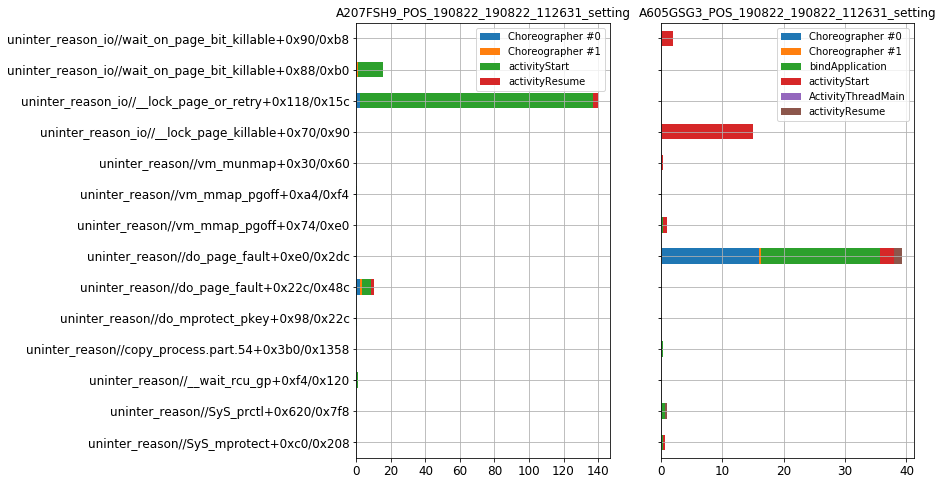

In [67]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

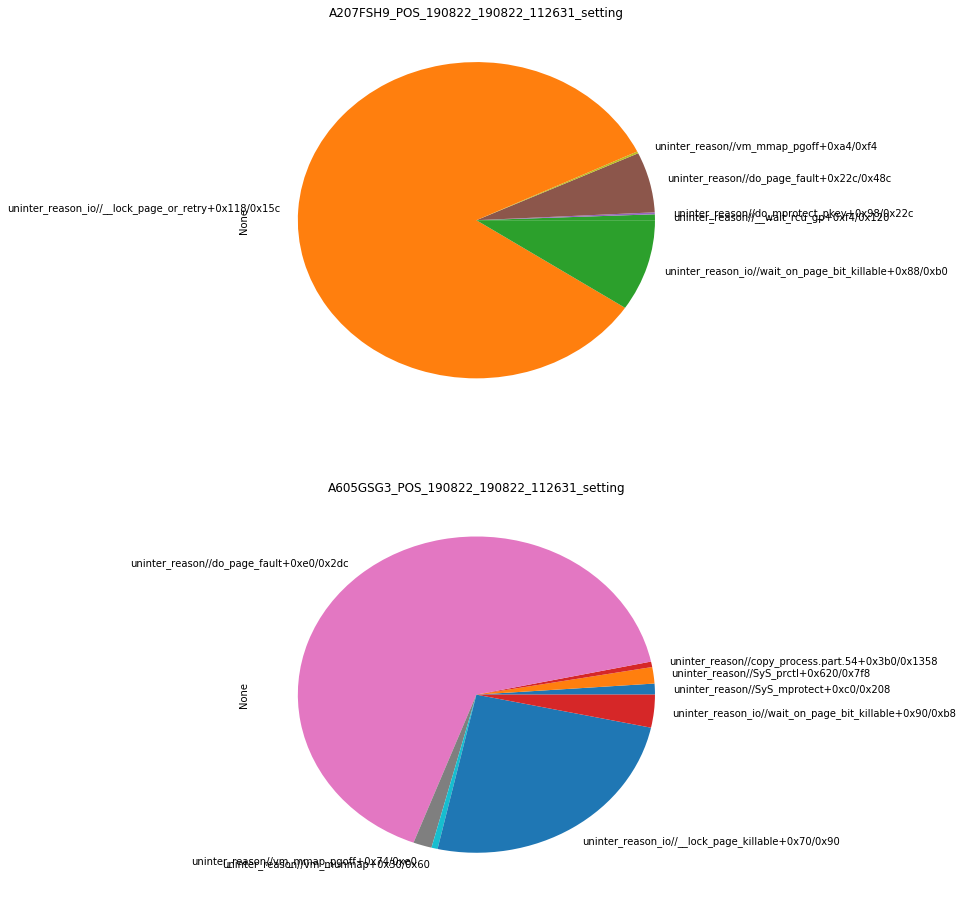

In [75]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

### Number of Running Cores(SUM)

Choreographer #0  \
A207FSH9_POS_190822_190822_112631_setting core0                 5   
                                          core1                 4   
                                          core2                 2   
                                          core3                 0   
                                          core4                13   
                                          core5                13   
                                          core6                 4   
                                          core7                 4   
A605GSG3_POS_190822_190822_112631_setting core0                 9   
                                          core1                 1   
                                          core2                 1   
                                          core3                 3   
                                          core4                25   
                                          core5                21   
                                          core6                11   
                                          core7                22   

                                                 Choreographer #1  \
A207FSH9_POS_190822_190822_112631_setting core0                 0   
                                          core1                 1   
                                          core2                 0   
                                          core3                 0   
                                          core4                12   
                                          core5                 2   
                                          core6                 0   
                                          core7                 0   
A605GSG3_POS_190822_190822_112631_setting core0                 1   
                                          core1                 0   
                                          core2                 0   
                                          core3                 0   
                                          core4                 4   
                                          core5                 1   
                                          core6                 3   
                                          core7                 4   

                                                 activityStart  \
A207FSH9_POS_190822_190822_112631_setting core0             60   
                                          core1            104   
                                          core2             49   
                                          core3              9   
                                          core4            330   
                                          core5            206   
                                          core6            290   
                                          core7            236   
A605GSG3_POS_190822_190822_112631_setting core0             31   
                                          core1              9   
                                          core2             31   
                                          core3             26   
                                          core4            398   
                                          core5            201   
                                          core6             99   
                                          core7             94   

                                                 activityResume  \
A207FSH9_POS_190822_190822_112631_setting core0              12   
                                          core1               1   
                                          core2               6   
                                          core3              13   
                                          core4              16   
                                          core5              25   
                                          core6              12   
                                          

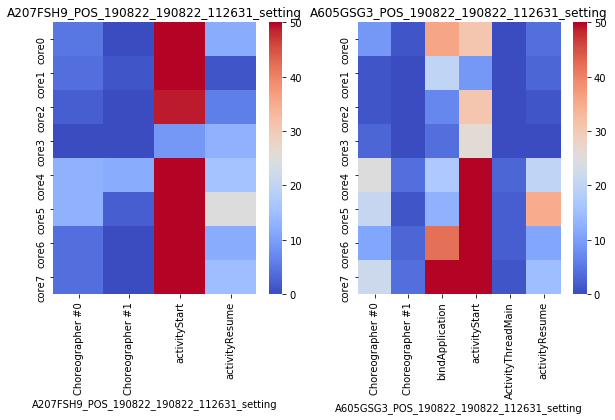

In [57]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [56]:
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,3,1,10,12,0,0,NaN
core1,0,0,10,0,0,0,NaN
core2,1,0,3,9,0,1,NaN
core3,1,0,2,12,0,0,NaN
core4,15,4,4,135,1,18,NaN
core5,9,0,3,76,0,0,NaN
core6,0,1,18,31,2,0,NaN
core7,6,1,15,30,0,10,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,3,0,16,9,0,4,NaN
core1,1,0,5,6,0,2,NaN
core2,0,0,1,11,0,0,NaN
core3,0,0,1,4,0,0,NaN
core4,6,0,7,137,1,1,NaN
core5,8,1,4,49,2,14,NaN
core6,8,1,5,38,0,7,NaN
core7,7,1,24,42,0,4,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,3,0,10,10,0,0,NaN
core1,0,0,5,3,0,1,NaN
core2,0,0,3,11,0,0,NaN
core3,2,0,1,10,0,0,NaN
core4,4,0,6,126,1,1,NaN
core5,4,0,6,76,0,21,NaN
core6,3,1,19,30,0,4,NaN
core7,9,2,22,22,1,1,NaN
